# **DNA as a Language: _k_-mers for Sequence Analysis**

First, let's download the data for this notebook.

The following commands will download (`wget`) the file `kmer-analysis.tar.gz` and then unarchive and decompress it (`tar`), resulting in the folder `kmer-analysis/`.
Then, the folder will be renamed (`mv`) to `data/`, and the now superfluous file `kmer-analysis.tar.gz` will be removed (`rm`).

In [9]:
! wget http://www.tnt.uni-hannover.de/edu/vorlesungen/AMLG/data/kmer-analysis.tar.gz
! tar -xzvf kmer-analysis.tar.gz
! mv -v kmer-analysis/ data/
! rm -v kmer-analysis.tar.gz

--2024-08-05 16:09:30--  http://www.tnt.uni-hannover.de/edu/vorlesungen/AMLG/data/kmer-analysis.tar.gz
Resolving www.tnt.uni-hannover.de (www.tnt.uni-hannover.de)... 130.75.31.71
Connecting to www.tnt.uni-hannover.de (www.tnt.uni-hannover.de)|130.75.31.71|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1465924 (1.4M) [application/x-gzip]
Saving to: ‘kmer-analysis.tar.gz’

kmer-analysis.tar.g 100%[===================>]   1.40M  --.-KB/s    in 0.02s   

2024-08-05 16:09:30 (66.6 MB/s) - ‘kmer-analysis.tar.gz’ saved [1465924/1465924]

kmer-analysis/
kmer-analysis/genomes/
kmer-analysis/genomes/e-coli-dh10b.fasta
kmer-analysis/homologous-genes/
kmer-analysis/homologous-genes/c-elegans.fasta
kmer-analysis/homologous-genes/d-melanogaster.fasta
kmer-analysis/homologous-genes/m-musculus.fasta
kmer-analysis/homologous-genes/p-troglodytes.fasta
kmer-analysis/homologous-genes/h-sapiens.fasta
renamed 'kmer-analysis/' -> 'data/'
removed 'kmer-analysis.tar.gz'


In [10]:
from typing import Dict, List

# Homologous genes

The `data/` folder contains two subfolders: `genomes/` and `homologous-genes/`.
The `genomes/` folder contains the reference genome of _E. coli_ strain DH10B as FASTA file `e-coli-dh10b.fasta`.
The `homologous-genes/` folder contains 5 FASTA files.
Each file contains sequences of one specific species:

- [Human](https://en.wikipedia.org/wiki/Human) (_Homo sapiens_): `h-sapiens.fasta`
- [Chimpanzee](https://en.wikipedia.org/wiki/Chimpanzee) (_Pan troglodytes_): `p-troglodytes.fasta`
- [House mouse](https://en.wikipedia.org/wiki/House_mouse) (_Mus musculus_): `m-musculus.fasta`
- [Threadworm](https://en.wikipedia.org/wiki/Caenorhabditis_elegans) (_Caenorhabditis elegans_): `c-elegans.fasta`
- [Fruit fly](https://en.wikipedia.org/wiki/Drosophila_melanogaster) (_Drosophila melanogaster_): `d-melanogaster.fasta`

The i-th sequences in the files are homologuous sequences of the same gene in the different species (i.e., they are similar due to shared ancestry).

The following function can be used to read a FASTA file into a dictionary.
In the dictionary, the sequence descriptions are the keys, and the actual sequences are the values.

In [11]:
def read_fasta_file(file_path: str) -> Dict[str, str]:
    with open(file=file_path, mode="r") as file:
        sequences = {}

        # Read the file line by line
        for line in file:
            # Process each line
            line = line.strip()
            if line.startswith(">"):
                current_description = line[1:]
                sequences[current_description] = ""
            else:
                sequences[current_description] += line

        return sequences

##### ❓ **Q1** &mdash; Reading in multiple FASTA files

Complete the following code to read in the 5 provided FASTA files from the `data/homologous-genes/` folder.

In [12]:
import os


def list_files_in_directory(directory: str) -> List[str]:
    file_list = []

    # Iterate over the files in the specified directory
    for root, _, files in os.walk(top=directory):
        for file in files:
            file_list.append(os.path.join(root, file))

    return file_list


# Print the list of files
for file in list_files_in_directory(directory="data/homologous-genes/"):
    sequences = read_fasta_file(file_path=file)
    print(f"Read {len(sequences)} sequences from '{file}': {list(sequences.keys())}")

Read 11 sequences from 'data/homologous-genes/c-elegans.fasta': ['tRNA', 'pyruvate kinase', 'phenylalanine hydroxylase', 'isocitrate dehydrogenase', 'succinyl-CoA ligase', 'UDP-glucose 4-epimerase', 'NADH dehydrogenase', 'malate dehydrogenase', 'acyl-CoA oxidase', 'tyrosine---tRNA ligase', 'alcohol dehydrogenase']
Read 11 sequences from 'data/homologous-genes/d-melanogaster.fasta': ['tRNA', 'pyruvate kinase', 'phenylalanine hydroxylase', 'isocitrate dehydrogenase', 'succinyl-CoA ligase', 'UDP-glucose 4-epimerase', 'NADH dehydrogenase', 'malate dehydrogenase', 'acyl-CoA oxidase', 'tyrosine---tRNA ligase', 'alcohol dehydrogenase']
Read 11 sequences from 'data/homologous-genes/m-musculus.fasta': ['tRNA', 'pyruvate kinase', 'phenylalanine hydroxylase', 'isocitrate dehydrogenase', 'succinyl-CoA ligase', 'UDP-glucose 4-epimerase', 'NADH dehydrogenase', 'malate dehydrogenase', 'acyl-CoA oxidase', 'tyrosine---tRNA ligase', 'alcohol dehydrogenase']
Read 11 sequences from 'data/homologous-genes/

# _k_-mers

_k_-mers are substrings of length $k$ contained within a biological sequence.
They are a fairly simple concept that turns out to be tremendously powerful.

Usually, the term _k_-mer refers to all of a sequence's subsequences of length $k$.
Using this definition, the sequence `ACGT` would have four monomers (`A`, `C`, `G`, `T`), three 2-mers (`AC`, `CG`, `GT`), two 3-mers (`ACG`, `CGT`), and one 4-mer (`ACGT`).
More generally, a sequence of length $L$ has $L - k + 1$ _k_-mers and $n^k$ total possible _k_-mers, where $n$ is the number of possible monomers.

Typically we extract _k_-mers from genomic assemblies or read data sets by running a $k$-length window across all of the sequences.
E.g., given the sequence `AGGATGAGACAGATAG` of length 16, you could extract the following 6-mers from it:

```
AGGATG
 GGATGA
  GATGAG
   ATGAGA
    TGAGAC
     GAGACA
      AGACAG
       GACAGA
        ACAGAT
         CAGATA
          AGATAG
```

_k_-mers are used in numerous applications, e.g.:

- The frequency of a set of _k_-mers in a species's genome, in a genomic region, or in a class of sequences can be used as a "signature" of the underlying sequence.
- With respect to disease, dinucleotide bias has been applied to the detection of genetic islands associated with pathogenicity.
- _k_-mer frequency and spectrum variation is heavily used in metagenomics analysis.

_k_-mers are most useful when they are long, because then they are specific.
That is, if you have a 31-mer taken from a human genome, it is pretty unlikely that another genome has that exact 31-mer in it.

> You can calculate the probability if you assume genomes are random: there are $n^k = 4^{31} = 4,611,686,018,427,387,904$ possible 31-mers&nbsp;&mdash;&nbsp;a lot.
> The human genome has a size of $L = 3,117,275,501$.
> We can hence extract $L - k + 1 = 3,117,275,501 - 31 + 1 = 3,117,275,471$ 31-mers from it.
> The probability that a random genome contains a specific 31-mer is hence $\frac{3,117,275,471}{4,611,686,018,427,387,904} \approx 0.0000000006$.
>
> An extension of this observation is that long _k_-mers are species specific.

##### ❓ **Q2** &mdash; Building _k_-mers

Complete the function `build_kmers()`.
The function shall do two things:

1. Build a list of _k_-mers for the given `sequence`.
2. Count the frequency of each _k_-mer.

As an example, for the `sequence = "GATTACA"` the function shall return `kmers = ['GAT', 'ATT', 'TTA', 'TAC', 'ACA', 'CAC', 'ACA']` and `kmer_counts = {'GAT': 1, 'ATT': 1, 'TTA': 1, 'TAC': 1, 'ACA': 2, 'CAC': 1}`.

In [13]:
def build_kmers(sequence: str, k: int) -> tuple[List[str], Dict[str, int]]:
    kmers = []
    kmer_counts = {}
    n_kmers = len(sequence) - k + 1

    for i in range(n_kmers):
        kmer = sequence[i : (i + k)]
        kmers.append(kmer)
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
        else:
            kmer_counts[kmer] = 1

    return kmers, kmer_counts


kmers, kmer_counts = build_kmers(sequence="GATTACACA", k=3)

print(kmers)
print(kmer_counts)

['GAT', 'ATT', 'TTA', 'TAC', 'ACA', 'CAC', 'ACA']
{'GAT': 1, 'ATT': 1, 'TTA': 1, 'TAC': 1, 'ACA': 2, 'CAC': 1}


# The _k_-mer spectrum

A method of visualizing _k_-mers, the _k_-mer spectrum, shows the multiplicity of each _k_-mer in a sequence versus the number of _k_-mers with that multiplicity.
The number of modes in a _k_-mer spectrum for a species' genome varies, with most species having a unimodal distribution.
However, all mammals have a multimodal distribution.

##### ❓ **Q3** &mdash; Computing a _k_-mer spectrum

Compute and plot the 7-mer spectrum of the provided _E. coli_ genome.
Here we use the DH10B strain, a widely used model organism.

> This [_E. coli_ genome](https://www.ncbi.nlm.nih.gov/nuccore/NZ_CP110018.1/) and others can be downloaded from the [NCBI](https://www.ncbi.nlm.nih.gov).

In [14]:
ecoli_genome = read_fasta_file(file_path="data/genomes/e-coli-dh10b.fasta")
ecoli_genome_sequence = ecoli_genome[
    "NZ_CP110018.1 Escherichia coli strain DH10B chromosome, complete genome"
]
print(f"Read E. coli genome with length {len(ecoli_genome_sequence):,}.")

Read E. coli genome with length 4,687,487.


In [15]:
current_k = 7
ecoli_kmers, ecoli_kmer_counts = build_kmers(
    sequence=ecoli_genome_sequence, k=current_k
)
ecoli_kmer_counts_values = list(ecoli_kmer_counts.values())
kmer_frequencies = range(max(ecoli_kmer_counts_values))
n_kmers_with_frequency = [[ecoli_kmer_counts_values.count(f)] for f in kmer_frequencies]

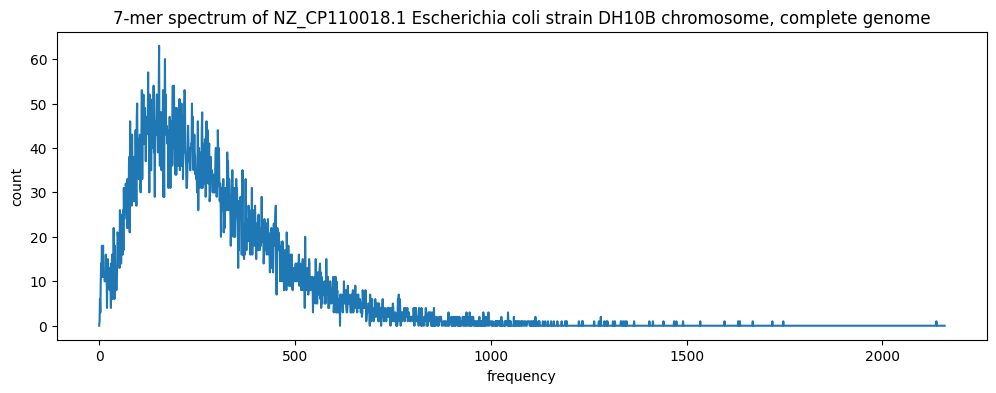

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(kmer_frequencies, n_kmers_with_frequency)
plt.title(label=f"{current_k}-mer spectrum of {list(ecoli_genome.keys())[0]}")
plt.xlabel("frequency")
plt.ylabel("count")
plt.show()

# The Jaccard index

One thing we can do is to use _k_-mers to compare genomes to genomes, or read data sets to read data sets.

One metric we can use for this comparisons is the Jaccard index, which is calculated by asking how many _k_-mers are shared between two samples (expressed as the cardinality of the intersection of the two _k_-mer sets) versus how many _k_-mers in total are in the combined samples (expressed as the cardinality of the union of the two _k_-mer sets):

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

<img src="images/intersection.png" width="200" />
<img src="images/union.png" width="200" />

##### ❓ **Q4** &mdash; Computing the Jaccard index

Complete the function `jaccard_index()` for the computation of the Jaccard index of two sets `a` and `b`.

In [17]:
def jaccard_index(a: set, b: set) -> float:
    if not a and not b:
        return None

    return len(a & b) / len(a | b)

In [18]:
test_strings = [
    ("", ""),
    ("", "A"),
    ("A", "A"),
    ("A", "C"),
    ("AC", "GT"),
    ("ACG", "GT"),
    ("ACG", "CGT"),
]

# Transform the list into a list of tuples of sets
test_sets = [(set(item1), set(item2)) for item1, item2 in test_strings]

# Compute and print the Jaccard indexes
for set_a, set_b in test_sets:
    print(f"J({set_a}, {set_b}) = {jaccard_index(a=set_a, b=set_b)}")

J(set(), set()) = None
J(set(), {'A'}) = 0.0
J({'A'}, {'A'}) = 1.0
J({'A'}, {'C'}) = 0.0
J({'A', 'C'}, {'T', 'G'}) = 0.0
J({'A', 'G', 'C'}, {'T', 'G'}) = 0.25
J({'A', 'G', 'C'}, {'T', 'G', 'C'}) = 0.5


##### ❓ **Q5** &mdash; Similarity of homologous genes

Now, let's compare the similarity of homologous genes in different species:

1. Compute all 10-mers for the DNA sequence of the pyruvate kinase gene in _H. sapiens_ and _P. troglodytes_.
2. Then, compute the Jaccard index between the two 10-mer sets.

In [19]:
human_genes = read_fasta_file(file_path="data/homologous-genes/h-sapiens.fasta")
human_pyruvate_kinase_sequence = human_genes["pyruvate kinase"]
print(
    f"H. sapiens pyruvate kinase DNA sequence length: {len(human_pyruvate_kinase_sequence):,}"
)

chimp_genes = read_fasta_file(file_path="data/homologous-genes/p-troglodytes.fasta")
chimp_pyruvate_kinase_sequence = chimp_genes["pyruvate kinase"]
print(
    f"P. troglodytes pyruvate kinase DNA sequence length: {len(chimp_pyruvate_kinase_sequence):,}"
)

current_k = 10

human_pyruvate_kinase_kmers, _ = build_kmers(
    sequence=human_pyruvate_kinase_sequence, k=current_k
)
chimp_pyruvate_kinase_kmers, _ = build_kmers(
    sequence=chimp_pyruvate_kinase_sequence, k=current_k
)

print(
    f"J = {jaccard_index(a=set(human_pyruvate_kinase_kmers), b=set(chimp_pyruvate_kinase_kmers))}"
)

H. sapiens pyruvate kinase DNA sequence length: 1,596
P. troglodytes pyruvate kinase DNA sequence length: 1,617
J = 0.024758842443729903


##### ❓ **Q6** &mdash; Comparison of homologous genes across species

Now, iterate through all genes and compute the Jaccard indexes between all possible species-species pairs of _k_-mer sets.

Store the computed Jaccard indexes in a similarity array with the dimensions `shape=[n_genes, n_species, n_species]`.

Use varying values for $k$.
(A good starting point is $k = 4$.)

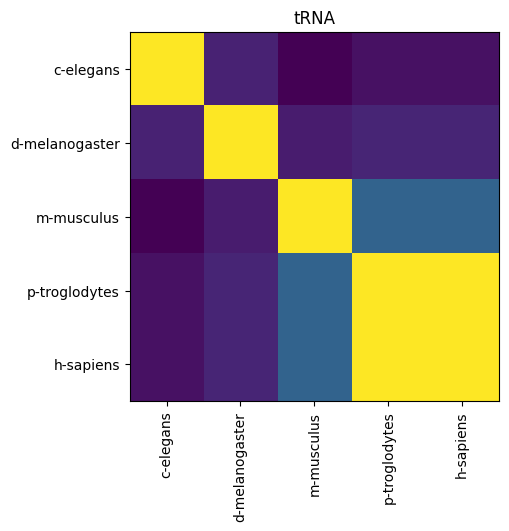

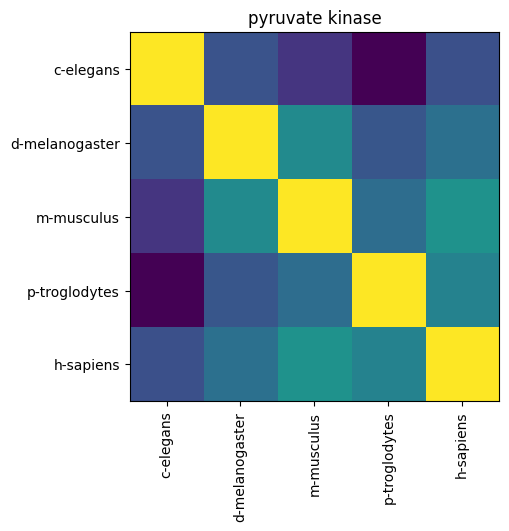

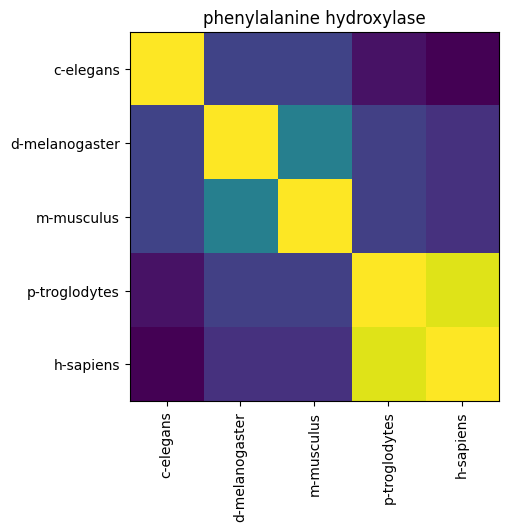

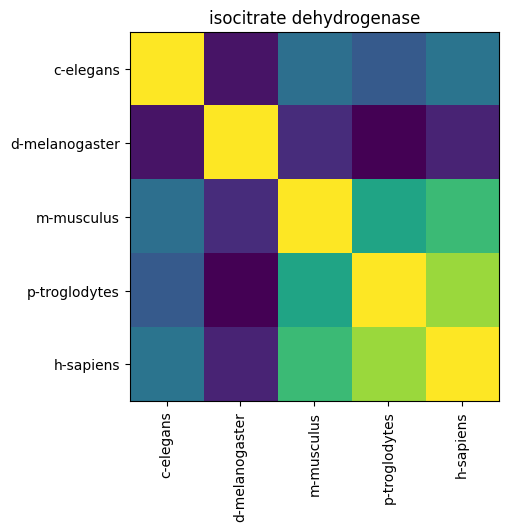

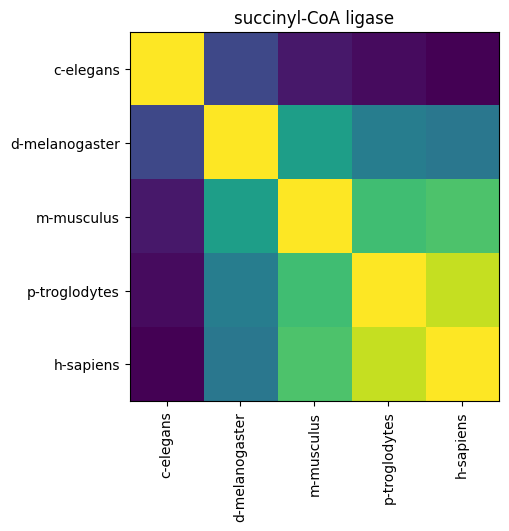

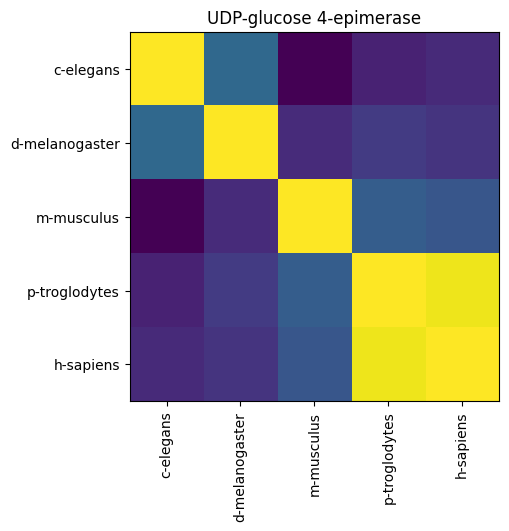

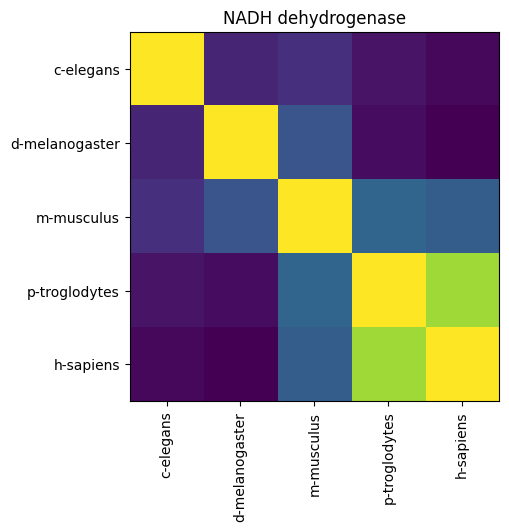

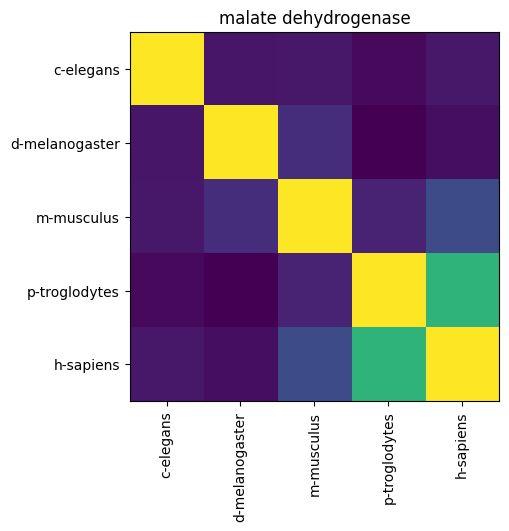

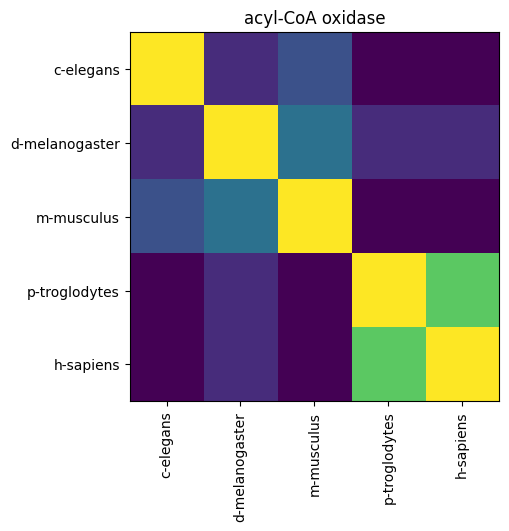

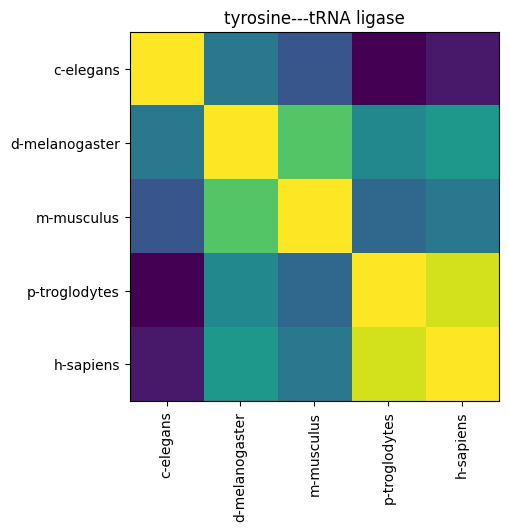

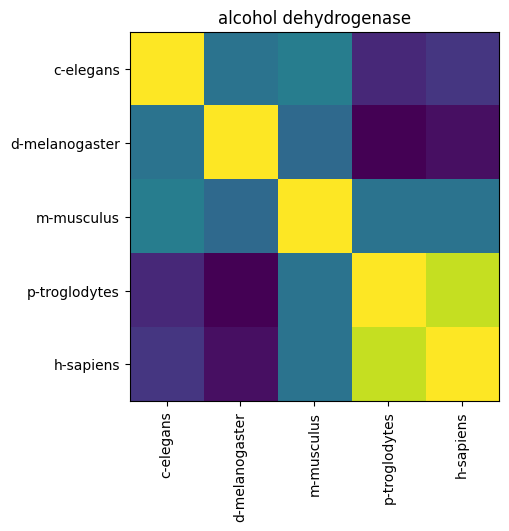

In [20]:
import numpy as np

current_k = 4

# Read in all gene sequences for all species
file_list = list_files_in_directory(directory="data/homologous-genes/")
all_sequences = {}
for file in file_list:
    species = os.path.splitext(os.path.basename(file))[0]
    sequences = read_fasta_file(file_path=file)
    all_sequences[species] = sequences

# Get all gene names
gene_names = list(all_sequences[list(all_sequences.keys())[0]].keys())
n_genes = len(gene_names)

# Get all species
speciess = list(all_sequences.keys())
n_species = len(speciess)

# Set up the similarity matrix
similarity_matrix = np.zeros(shape=[n_genes, n_species, n_species])

for i, gene_name in enumerate(gene_names):
    for j, species1 in enumerate(speciess):
        sequence1 = all_sequences[species1][gene_name]
        for l, species2 in enumerate(speciess):
            sequence2 = all_sequences[species2][gene_name]
            kmers1, _ = build_kmers(sequence=sequence1, k=current_k)
            kmers2, _ = build_kmers(sequence=sequence2, k=current_k)
            jaccard = jaccard_index(a=set(kmers1), b=set(kmers2))
            similarity_matrix[i][j][l] = jaccard
    plt.imshow(X=similarity_matrix[i])
    plt.title(label=f"{gene_name}")
    plt.xticks(ticks=range(len(speciess)), labels=speciess, rotation=90)
    plt.yticks(ticks=range(len(speciess)), labels=speciess)
    plt.show()